In [57]:
import pennylane as qml
import pennylane.numpy as np

num_points = [6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 70, 80, 90, 100]

In [58]:
sim_values = []
x_test = [2*i*np.pi/1000 for i in range(1000)]
y_test = np.sin(x_test)

In [59]:
dev = qml.device('default.qubit', wires=3)

In [60]:
def state_prep(a):
    qml.RY(a, wires=0)
    qml.CNOT(wires=[0, 1])

In [61]:
def layer(angles):
    qml.Rot(*angles[4], wires=2)
    qml.Hadamard(wires=2)
    
    def ctrl_func(angles_inner):
        for wire in range(2):
            qml.Rot(*angles_inner[wire], wires=wire)
        qml.CNOT(wires=[0, 1])
        
        for wire in range(2, 4):
            qml.Rot(*angles_inner[wire], wires=(wire-2))
        qml.CNOT(wires=[0, 1])
    
    qml.ctrl(ctrl_func, control=[2])(angles[:4])
    
    qml.Hadamard(wires=2)

# length of angles = 5

In [62]:
@qml.qnode(dev)
def circuit(weights, x):
    state_prep(x)
    
    for layer_weights in weights:
        layer(layer_weights)
    
    return qml.expval(qml.PauliZ(0))

In [63]:
def var_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [64]:
def cost(weights, bias, X, Y):
    predictions = var_classifier(weights, bias, X.T)
    return loss(Y, predictions)

In [65]:
def loss(Y, preds):
    return np.mean((Y - qml.math.stack(preds)) ** 2)

In [66]:
def accuracy(labels, preds):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, preds))
    acc = acc / len(labels)
    return acc

In [67]:
y_test = (y_test+1)/2

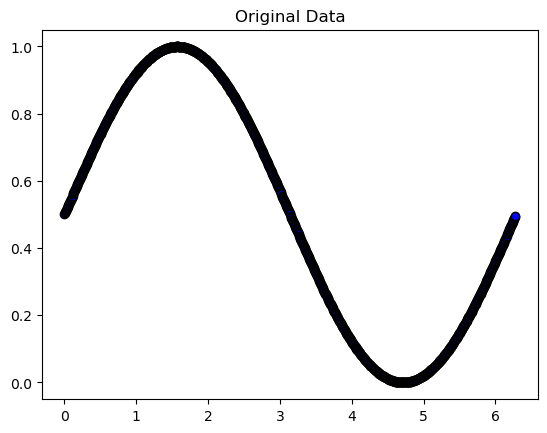

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(x_test, y_test, c="b", marker="o", ec="k")
plt.title("Original Data")
plt.show()

In [69]:
np.random.seed(0)
num_data = len(x_test)
num_train = int(0.75 * num_data)

index = np.random.permutation(range(num_data))

x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

feats_train = x_test_np[index[:num_train]]
labels_train = y_test_np[index[:num_train]]

feats_val = x_test_np[index[num_train:]]
labels_val = y_test_np[index[num_train:]]

In [82]:
num_qubits = 3
num_layers = 5

weights_init = 0.01 * np.random.randn(num_layers, 5, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = qml.NesterovMomentumOptimizer(0.2)
batch_size = 30


In [83]:
type(x_test)

list

In [86]:
weights = weights_init
bias = bias_init

for it in range(100):
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = np.array(feats_train[batch_index])
    labels_train_batch = np.array(labels_train[batch_index])
    
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, labels_train_batch)
    
    preds_train = np.sign(var_classifier(weights, bias, feats_train.T))
    preds_val = np.sign(var_classifier(weights, bias, feats_val.T))
    
    acc_train = accuracy(labels_train, preds_train)
    acc_val = accuracy(labels_val, preds_val)
    
    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, feats_test, labels_test)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )


Iter:     2 | Cost: 0.2736296 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:     4 | Cost: 0.0447274 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:     6 | Cost: 0.0399688 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:     8 | Cost: 0.0146407 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    10 | Cost: 0.0017358 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    12 | Cost: 0.0024562 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    14 | Cost: 0.0024995 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    16 | Cost: 0.0003499 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    18 | Cost: 0.0001388 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    20 | Cost: 0.0001641 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    22 | Cost: 0.0000331 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    24 | Cost: 0.0000170 | Acc train: 0.0040000 | Acc validation: 0.0000000
Iter:    26 | Cost: 0.000017